# Yeast Cell Mating Projection Growth with SpatialPy

## Definition of the model

### Imports and definitions

In [1]:
import os
import sys
import math
sys.path.insert(1, "../..")
import numpy as np
import matplotlib.pyplot as plt
import numpy
import spatialpy

In [2]:
spatialpy.__version__

'1.1.0'

In [27]:
class Fluid(spatialpy.Geometry):
    def __init__(self, external_radius):
        self.ers = external_radius**2
        
    def count(self, domain):
        Npts = 0
        for i in range(domain.coordinates().shape[0]):
            if self.inside(domain.coordinates()[i,:],False):
                Npts+=1
        return Npts

    
    def inside(self, x, on_boundary):
        return x[0]**2 + x[1]**2 > self.ers

In [28]:
class Interior(spatialpy.Geometry):
    def __init__(self, internal_radius):
        self.irs = internal_radius**2
        
    def count(self, domain):
        Npts = 0
        for i in range(domain.coordinates().shape[0]):
            if self.inside(domain.coordinates()[i,:],False):
                Npts+=1
        return Npts

    
    def inside(self, x, on_boundary):
        return x[0]**2 + x[1]**2 < self.irs

In [29]:
class CellWall(spatialpy.Geometry):
    def __init__(self, external_radius, internal_radius):
        self.ers = external_radius**2
        self.irs = internal_radius**2
        
    def count(self, domain):
        Npts = 0
        for i in range(domain.coordinates().shape[0]):
            if self.inside(domain.coordinates()[i,:],False):
                Npts+=1
        return Npts
    
    def inside(self, x, on_boundary):
        radius_sqr = x[0]**2 + x[1]**2
        return radius_sqr < self.ers and radius_sqr > self.irs

In [30]:
class Polarisome(spatialpy.Geometry):
    def __init__(self, external_radius, internal_radius, angular_width):
        self.ers = external_radius**2
        self.irs = internal_radius**2
        self.angular_width = angular_width
        
    def count(self, domain):
        Npts = 0
        for i in range(domain.coordinates().shape[0]):
            if self.inside(domain.coordinates()[i,:],False):
                Npts+=1
        return Npts
        
    def inside(self, x, on_boundary):
        radius_sqr = x[0]**2 + x[1]**2
        theta = numpy.degrees(numpy.arccos( x[1] / numpy.sqrt(x[0]**2 + x[1]**2) ))
        return radius_sqr < self.ers and radius_sqr > self.irs and theta < self.angular_width

### Model

In [45]:
class YeastCellMatingProjectionGrowth(spatialpy.Model):
    FLUID = 1
    CELL_WALL = 2
    INTERIOR = 3
    
    def __init__(self, model_name="Yeast Cell Mating Projection Growth"):
        spatialpy.Model.__init__(self, model_name)
        
        # System Constants
        rhof = 1000
        rhoc = 1100
        rhoi = 1500
        gravity = [0, -1, 0]
        nu0 = 1e-3
        
        # calculated values
        E=1e6
        Pratio=0.3975
        Gmax=E/(2.0*(1.0+Pratio))
        Kw = 2.0*Gmax*(1+Pratio)/(3.0*(1.0-2.0*Pratio)) 
        c0 = numpy.sqrt(Kw/rhof)
        
        
        # Discretizations
        Npx = 100
        
        # Compute domain bounds (including the boundary)
        L = 50e-6
        radius_external = 0.2*L
        radius_internal = 0.15*L
        deltaf = L/Npx
        xmin = ymin = -L/2
        xmax = ymax = L/2
        
        vtot = L*L
        vcelltot = math.pi*radius_external*radius_external
        vcellint = math.pi*radius_internal*radius_internal
        vcell    = vcelltot-vcellint                
        vfluid   = vtot-vcelltot
        
        
        
        
        # Create the Domain object
        domain = spatialpy.Domain.create_2D_domain(
            xlim=(xmin, xmax), ylim=(ymin, ymax), numx=Npx, numy=Npx, 
            nu=nu0, c0=c0, gravity=gravity, fixed=False
        )
        self.add_domain(domain)
        
        # set the properties of the Fluid Region
        fluid_region = Fluid(radius_external)
        Nptf = fluid_region.count(domain)
        mfluid = vfluid*rhof/Nptf
        domain.set_properties(fluid_region, type_id="Fluid", rho=rhof, mass=mfluid)
        # Cell Wall Region
        cell_region = CellWall(radius_external, radius_internal)
        Nptc = cell_region.count(domain)
        mcell = vcell*rhoc/Nptc
        domain.set_properties(cell_region, type_id="CellWall", rho=rhoc, mass=mcell)
        # Polarisome (polarized cap: 22 angural width)
        polarisome = Polarisome(radius_external, radius_internal, 22)
        self.domain.set_properties(polarisome, type_id="Polarisome")
        # Cell Interior Region
        interior_region = Interior(radius_internal)
        Npti = interior_region.count(domain)
        minterior = vcellint*rhoi/Npti
        domain.set_properties(interior_region, type_id="Interior", rho=rhoi, mass=minterior)


        
#         # Compute volume and mass per particle
#         vol = L**2
#         Cvol = math.pi*radius_external**2
#         CIvol = math.pi*radius_internal**2
#         CWvol = Cvol-CIvol
#         Fvol = vol-Cvol
        
        # Types
        #self.set_type(fluid_region, self.FLUID)
        #self.set_type(cell_region, self.CELL_WALL)
        #self.set_type(interior_region, self.INTERIOR)
        
        # Timespan
        dt = 1e-10
        #nt = 40000
        nt = 2000
        freq_results = 1000
        

        # Setting staticDomain to False allows particles to move within the system.
        self.staticDomain = False
    
        self.timespan(np.arange(0, nt*dt+dt, freq_results*dt), timestep_size=dt)

In [46]:
model = YeastCellMatingProjectionGrowth()

In [47]:
model.tspan

[0.e+00 1.e-07 2.e-07]


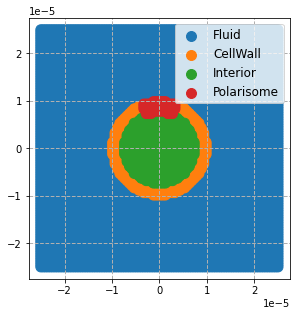

In [48]:
model.domain.plot_types(use_matplotlib=True)

In [49]:
%time results = model.run()

CPU times: user 1.27 s, sys: 16.1 ms, total: 1.29 s
Wall time: 4min 11s


In [50]:
results.get_timespan()

[0.e+00 1.e-07 2.e-07]


In [ ]:
#results.plot_property('type',animated=True)

In [ ]:
results.plot_property('mass',t_ndx=0, use_matplotlib=True)
results.plot_property('mass',t_ndx=-1 , use_matplotlib=True)

In [ ]:
results.plot_property('rho',t_ndx=-1, use_matplotlib=True)
results.plot_property('nu',t_ndx=-1 , use_matplotlib=True)